In [1]:
import sys
# setting path
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from src import io, var, utils, fourier, lin_reg, reconstruction, physics
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

In [2]:
#### define wavenumber range
nhi = 12
nhj = 12
ll = np.arange(-(nhj/2-1),nhj/2+1)
kk = np.arange(0,nhi)

#### initialise triangle
grid = var.grid()
cell = var.topo_cell()

In [31]:
np.random.seed(333)

r_row = np.random.randint(0,144-5,size=10)
r_col = np.random.randint(0,144-5-1,size=10)
r_entries = np.random.randint(0,((144-5)*2)-1,size=10)
r_ampl = np.random.random(size=10)

sz = 10
nk = np.random.randint(0,12, size=sz)
nl = np.random.randint(-5,6, size=sz)

for ii  in range(sz):
    if nk[ii] == 0 and nl[ii] < 0:
        nk[ii] += np.random.randint(1,11)
pts = [item for item in zip(nk,nl)]

pts = np.array(list(set(pts)))

nk = pts[:,0]
nl = pts[:,1]

sz = len(pts)

Ak = np.random.random(size=sz) * 100.0
Al = np.random.random(size=sz) * 100.0

sck = np.random.randint(0,2,size=sz)
scl = np.random.randint(0,2,size=sz)

nhi = 12
nhj = 12
freqs_ref = np.zeros((nhi,nhj))

cnt = 0
for pt in pts:
    kk, ll = pt
    ll += 5
    freqs_ref[ll, kk] = Ak[cnt]
            
    cnt += 1
    
ref_sum = freqs_ref.sum()

In [32]:
vid = utils.delaunay(grid, cell, res_x=337, res_y=652)#, xmax=, ymax=10.0)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)

cell.topo = np.zeros_like(cell.lat_grid)
cell.get_masked(triangle)

# cell.topo[...] = 0.0

def sinusoidal_basis(Ak, nk, Al, nl, sc, typ):        
    if sc == 0:
        bf = Ak * np.cos(nk * cell.lon_grid + nl * cell.lat_grid)
    else:
        bf = Ak * np.sin(nk * cell.lon_grid + nl * cell.lat_grid)
    
    return bf

for ii in range(sz):
    cell.topo += sinusoidal_basis(Ak[ii], nk[ii], Al[ii], nl[ii], sck[ii], 'k')

0.001994041274252903


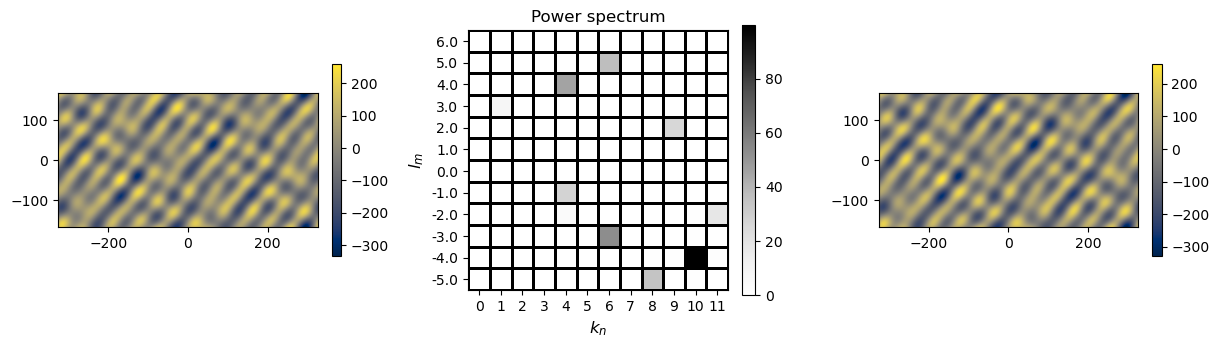

379.9440470943231
[99.86218671 53.32820663 45.82517866 36.81788859 34.7374613  27.5488758
 25.9108895  17.51016549  7.92223926  4.19962154]
[99.79900759 53.38126679 45.83517927 36.83045249 34.69296044 27.68184612
 25.91974767 17.50952703  7.85250277  4.21071179  1.60943583  1.53540331
  1.22602634  1.17880414  0.90335747  0.89988969  0.58647082  0.5442786
  0.51275155  0.50871736  0.50137188  0.49566605  0.48572412  0.47632506
  0.45384884]


In [33]:
cell.mask[...] = True
# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle, mask=cell.mask)

nhi = 12
nhj = 12
fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
a_m, data_recons = lin_reg.do(fobj, cell, lmbda=0.0)

fobj.get_freq_grid(a_m)
freqs = np.abs(fobj.ampls)

dat_2D = reconstruction.recon_2D(data_recons, cell)

analysis = var.analysis()
analysis.get_attrs(fobj, freqs)

ideal = physics.ideal_pmf(U=10.0, V=0.1)
pmf_ff = ideal.compute_uw_pmf(analysis, summed=True)
print(pmf_ff)

fs = (15,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0,0] = fig_obj.phys_panel(axs[0,0], cell.topo * cell.mask)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
axs[2] = fig_obj.phys_panel(axs[2], cell.topo)
plt.show()

print(freqs.sum())
print(np.sort(Ak)[::-1])
print(np.sort(freqs.ravel())[::-1][:25])
no_reg_sum = freqs.sum()
no_reg_err = np.linalg.norm(freqs - freqs_ref)

In [34]:
# ampls = np.fft.fft2(dat_2D) 
ampls = np.fft.rfft2(dat_2D) 
ampls /= ampls.size
ampls = np.abs(ampls)

print(np.sort(ampls.reshape(-1,))[::-1][:25])

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
# kks = np.fft.fftfreq(cell.topo.shape[1])
# lls = np.fft.fftfreq(cell.topo.shape[0])

kks = np.fft.rfftfreq((ampls.shape[1] * 2) - 1, d=1.0).reshape(-1,1)
lls = np.fft.fftfreq((ampls.shape[0]), d=1.0).reshape(1,-1)

kkg, llg = np.meshgrid(kks, lls)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = ampls
analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

ideal = physics.ideal_pmf(U=10.0, V=0.1)
uw_ref = ideal.compute_uw_pmf(analysis, summed=True)

print(ampls.sum())
print(uw_ref)

[99.49381185 53.21802132 45.69501052 36.71782114 34.58686576 27.59719216
 25.84048239 17.45598107  7.828489    4.197835    1.60451401  1.53070789
  1.22227702  1.17519923  0.90059491  0.89713773  0.58467733  0.54261414
  0.5111835   0.50716165  0.49983864  0.49415025  0.48423872  0.47486841
  0.45246092]
379.13378601457003
0.0019778132884863036


# Double reg

361.87304980659985
0.002008817364979423
1.5675936992438764


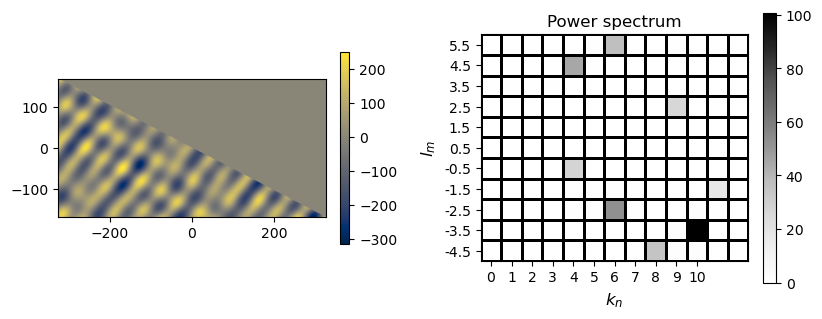

In [35]:
nhi = 12
nhj = 12

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

# cell.mask[...] = True
# cell.get_masked(triangle, mask=cell.mask)

fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
am_orig, data_recons_orig = lin_reg.do(fobj, cell, lmbda=0.5)

dat_2D_orig = reconstruction.recon_2D(data_recons_orig, cell)

fobj.get_freq_grid(am_orig)
freqs = np.abs(fobj.ampls)

############

fq_cpy = np.copy(freqs)

indices = []
for _ in range(25):
    max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
    indices.append(max_idx)
    fq_cpy[max_idx] = 0.0

k_idxs = [pair[1] for pair in indices]
l_idxs = [pair[0] for pair in indices]

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

fobj.set_kls(k_idxs, l_idxs, recompute_nhij = True)
fobj.do_full(cell)

am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-6)

fobj.get_freq_grid(am)
dat_2D = reconstruction.recon_2D(data_recons, cell)

freqs = np.abs(fobj.ampls)

analysis = var.analysis()
analysis.get_attrs(fobj, freqs)

ideal = physics.ideal_pmf(U=10.0, V=0.1)
pmf_ff = ideal.compute_uw_pmf(analysis, summed=True)

print(freqs.sum())
print(pmf_ff)

print((pmf_ff - uw_ref)/(uw_ref) * 100.0)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()